In [1]:
from numpy import loadtxt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Load

In [20]:
# load dataset

label = 0

X = loadtxt('C:/Users/user/quantum_image_classifier/Image Preprocessing/Dataset One-vs-All/x_train_4features_' + str(0) + '.txt', delimiter=',')

X_test = loadtxt('C:/Users/user/quantum_image_classifier/Image Preprocessing/Dataset One-vs-All/x_test_4features_' + str(0) + '.txt', delimiter=',')

In [21]:
X.shape[0]

1008

In [22]:
Y = np.zeros((X.shape[0],))
Y[:int(X.shape[0]/2)] = 1
Y[int(X.shape[0]/2):] = -1

Y_test = np.zeros((X_test.shape[0],))
Y_test[:int(X_test.shape[0]/2)] = 1
Y_test[int(X_test.shape[0]/2):] = -1

In [23]:
print(X.shape, Y.shape)
print(X_test.shape, Y_test.shape)

(1008, 4) (1008,)
(216, 4) (216,)


# Create Quantum Model

In [24]:
%matplotlib inline

import pennylane as qml
from pennylane import numpy as np
import numpy
from pennylane.optimize import *

from qiskit import *
from qiskit.providers.aer.noise import NoiseModel

## Choose a Quantum Device

You can choose between several different backend (including the one ownwed by IBM)

In [25]:
def select_backend(num_qubit, selected, shots):
    if selected == 'pennylane_statevector_simulator':
        # PennyLane Statevector simulator
        dev = qml.device("default.qubit", wires=num_qubit)

    elif selected == 'qiskit_noisefree_qasm_simulator':
        # Qiskit QASM simulator (noise-free)
        dev = qml.device("qiskit.aer", wires=num_qubit, shots=shots, analytic=False, backend='qasm_simulator')

    elif selected == 'qiskit_noisy_qasm_simulator':
        # Qiskit QASM simulator + noise
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibmq_athens')
        noise_model = NoiseModel.from_backend(backend)
        dev = qml.device("qiskit.aer", wires=num_qubit, shots=shots, noise_model = noise_model, analytic=False, backend='qasm_simulator')
        
    return dev

In [26]:
num_qubit = 2
dev = select_backend(2, 'pennylane_statevector_simulator', 1024)

## Loss and Acc Metric

In [27]:
# MSE
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

# Cost-Sensitive Learning for Imbalanced Classification
def confusion_matrix_loss(labels, predictions):
    cost_matrix=np.array([[0, 0.9], [0.1, 0]])
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    # count the TP, TN, FP, and FN
    for l, p in zip(labels, predictions):
        if l == 1:
            if p == 1:
                TP += 1
            else:
                FN += 1
        else:
            if p == 1:
                FP += 1
            else:
                TN += 1
            
    # create the confusion matrix
    CM = np.array([[TN, FN], [FP, TP]])
    
    # calculate loss
    loss = float(np.sum(CM*cost_matrix))/len(labels)

    return loss

# true predictions/total predictions
def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / len(labels)

    return acc

In [28]:
confusion_matrix_loss(Y_train, predictions_train)

NameError: name 'Y_train' is not defined

In [164]:
square_loss(Y_train, predictions_train)

0.9032258064516129

In [200]:
cost_matrix = np.array([[0, 0.9], [0.1, 0]])

In [181]:
loss_weight = np.unique(Y, return_counts=True)[1]/np.sum(np.unique(Y, return_counts=True)[1])
loss_weight

array([0.9, 0.1])

## Quantum Amplitude Encoding Function

In [29]:
# a function to calculate the angle β

def beta(s, j, X_sample):
    # numerator index
    index_num = (2*j-1)*(2**(s-1))
    # denominator index
    index_den = (j-1)*(2**s)
    
    num = np.sqrt(np.sum(abs(X_sample[index_num : index_num+2**(s-1)])**2))
    den = np.sqrt(np.sum(abs(X_sample[index_den : index_den+2**(s)])**2))
    
    if den == 0:
        #print("Zero denominator!")
        beta = 0
    else:
        beta = 2*np.arcsin(num/den)
    
    return beta

In [30]:
def get_angles(x):
    beta_2_1 = beta(2, 1, x)
    beta_1_2 = beta(1, 2, x)
    beta_1_1 = beta(1, 1, x)
    
    return np.array([beta_2_1, beta_1_2, beta_1_1])

In [167]:
def U3_gate(θ, qubit):
    qml.RX(np.pi/2, wires=qubit)
    qml.RZ(θ, wires=qubit)
    qml.RX(-np.pi/2, wires=qubit)

In [132]:
def statepreparation(a):
    qml.RY(a[0], wires=0)
    
    qml.RX(np.pi/2, wires=1)
    qml.RZ(a[1]/2, wires=1)
    qml.RX(-np.pi/2, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(np.pi/2, wires=1)
    qml.RZ(-a[1]/2, wires=1)
    qml.RX(-np.pi/2, wires=1)
    qml.CNOT(wires=[0, 1])
    
    qml.PauliX(wires=0)
    qml.RX(np.pi/2, wires=1)
    qml.RZ(a[2]/2, wires=1)
    qml.RX(-np.pi/2, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(np.pi/2, wires=1)
    qml.RZ(-a[2]/2, wires=1)
    qml.RX(-np.pi/2, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.PauliX(wires=0)


In [31]:
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(-a[1]/2, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[1]/2, wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(-a[2]/2, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2]/2, wires=1)
    qml.PauliX(wires=0)

In [32]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0])
ang = get_angles(x)


@qml.qnode(dev)
def test(angles=None):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(angles=ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev._state))

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [0.56397465 0.         1.95009208]
amplitude vector:  [[0.53896774 0.79503606]
 [0.27826503 0.        ]]


## Define the Layer

In [33]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

## Build the Quantum Circuit, Define Cost Function, Create VQC

In [34]:
@qml.qnode(dev)
def circuit(weights, angles=None):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(var, angles=None):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles=angles) + bias


def cost(weights, features, labels):
    predictions = [variational_classifier(weights, angles=f) for f in features]
    return square_loss(labels, predictions)

# Data Prep

## Data (Padding), Normalization and Data Encoding

In [35]:
# train and val

print("First X train sample (original)  :", X[0])

# # pad the vectors to size 2^2 with constant values
# padding = 0.3 * np.ones((len(X), 1))
# X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
# print("First X sample (padded)    :", X_pad[0])

X_pad = X.copy()

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X train sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

First X train sample (original)  : [ 3.96752304 -1.15630211  2.33858651 -1.80692626]
First X train sample (normalized): [ 0.78092007 -0.22759276  0.46029957 -0.35565388]
First features sample      : [1.24161413 1.31568975 0.56717374]


In [36]:
sampel = 436
np.sqrt(X_norm[sampel, 0]**2 + X_norm[sampel, 1]**2 + X_norm[sampel, 2]**2 + X_norm[sampel, 3]**2)

1.0

In [37]:
print("First X test sample (original)  :", X_test[0])

# # pad the vectors to size 2^2 with constant values
# padding = 0.3 * np.ones((len(X_test), 1))
# X_pad = np.c_[np.c_[X_test, padding], np.zeros((len(X_test), 1))]
# print("First X sample (padded)    :", X_pad[0])

X_pad = X.copy()

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X test sample (normalized):", X_norm[0])

# angles for state preparation are new features
feats_test = np.array([get_angles(x) for x in X_norm])
print("First test features sample      :", feats_test[0])

First X test sample (original)  : [ 4.83885093  0.44290373  0.99533214 -0.38530635]
First X test sample (normalized): [ 0.78092007 -0.22759276  0.46029957 -0.35565388]
First test features sample      : [1.24161413 1.31568975 0.56717374]


In [38]:
sampel = 17
np.sqrt(X_norm[sampel, 0]**2 + X_norm[sampel, 1]**2 + X_norm[sampel, 2]**2 + X_norm[sampel, 3]**2)

1.0

In [39]:
# split X and y to train and validation

from sklearn.model_selection import train_test_split

feats_train, feats_val, Y_train, Y_val = train_test_split(features, Y, test_size=0.2, random_state=2020)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=2020)

In [40]:
print(X_train.shape, feats_train.shape, Y_train.shape)
print(X_val.shape, feats_val.shape, Y_val.shape)
print(X_test.shape, feats_test.shape, Y_test.shape)

(806, 4) (806, 3) (806,)
(202, 4) (202, 3) (202,)
(216, 4) (1008, 3) (216,)


# Training

## Qubits, Layers and Weights Initialization

In [49]:
# First we initialize the hyperparameters

num_qubits = 2  # 4 label = 4 class = log2(4) quibits = 2 qubits
num_layers = 6  # QNN layer
learning_rate = 0.01

opt = RMSPropOptimizer(stepsize=learning_rate)
batch_size = 32
max_iter = 100

var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)  # weights and bias initialization

In [50]:
num_train = X_train.shape[0]
num_train

806

## Training Iteration

In [51]:
# training

# array to save the training & val accuracy and loss history as the training goes
train_history = np.array([])
val_history = np.array([])
train_loss_history = np.array([])
val_loss_history = np.array([])
iter_history = np.array([])

var = var_init


# train the variational classifier
for it in range(max_iter):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, angles=f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, angles=f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    train_loss = cost(var, feats_train, Y_train)
    val_loss = cost(var, feats_val, Y_val)
    
    print(
        "Iter: {:5d} | Train Loss: {:0.7f} | Validation Loss: {:0.7f} | Train Acc: {:0.7f} | Validation Acc: {:0.7f} "
        "".format(it + 1, train_loss, val_loss, acc_train, acc_val)
    )
    
    iter_history = np.append(iter_history, it+1)
    train_loss_history = np.append(train_loss_history, train_loss)
    val_loss_history = np.append(val_loss_history, val_loss)
    train_history = np.append(train_history, acc_train)
    val_history = np.append(val_history, acc_val)
    
print("The training session is finished")

Iter:     1 | Train Loss: 0.9794858 | Validation Loss: 0.8758615 | Train Acc: 0.6302730 | Validation Acc: 0.6683168 
Iter:     2 | Train Loss: 0.9564546 | Validation Loss: 0.8617457 | Train Acc: 0.6352357 | Validation Acc: 0.6831683 
Iter:     3 | Train Loss: 0.9732549 | Validation Loss: 0.8687535 | Train Acc: 0.6339950 | Validation Acc: 0.6831683 
Iter:     4 | Train Loss: 0.9431065 | Validation Loss: 0.8497833 | Train Acc: 0.6401985 | Validation Acc: 0.6782178 
Iter:     5 | Train Loss: 0.9381085 | Validation Loss: 0.8430778 | Train Acc: 0.6451613 | Validation Acc: 0.6930693 
Iter:     6 | Train Loss: 0.9317188 | Validation Loss: 0.8376845 | Train Acc: 0.6488834 | Validation Acc: 0.6980198 
Iter:     7 | Train Loss: 0.9128163 | Validation Loss: 0.8231820 | Train Acc: 0.6612903 | Validation Acc: 0.6980198 
Iter:     8 | Train Loss: 0.8938763 | Validation Loss: 0.8109474 | Train Acc: 0.6464020 | Validation Acc: 0.7128713 
Iter:     9 | Train Loss: 0.8883357 | Validation Loss: 0.8096277

Iter:    72 | Train Loss: 0.6046852 | Validation Loss: 0.6054832 | Train Acc: 0.8039702 | Validation Acc: 0.7920792 
Iter:    73 | Train Loss: 0.6045943 | Validation Loss: 0.6105012 | Train Acc: 0.7990074 | Validation Acc: 0.8118812 
Iter:    74 | Train Loss: 0.6027542 | Validation Loss: 0.6054486 | Train Acc: 0.7990074 | Validation Acc: 0.7871287 
Iter:    75 | Train Loss: 0.6035812 | Validation Loss: 0.6052907 | Train Acc: 0.7928040 | Validation Acc: 0.8168317 
Iter:    76 | Train Loss: 0.6024279 | Validation Loss: 0.6044166 | Train Acc: 0.8002481 | Validation Acc: 0.7970297 
Iter:    77 | Train Loss: 0.6025456 | Validation Loss: 0.6010779 | Train Acc: 0.7952854 | Validation Acc: 0.8118812 
Iter:    78 | Train Loss: 0.6016248 | Validation Loss: 0.6002020 | Train Acc: 0.7952854 | Validation Acc: 0.8118812 
Iter:    79 | Train Loss: 0.6017051 | Validation Loss: 0.5998596 | Train Acc: 0.8002481 | Validation Acc: 0.8019802 
Iter:    80 | Train Loss: 0.6006806 | Validation Loss: 0.6020078

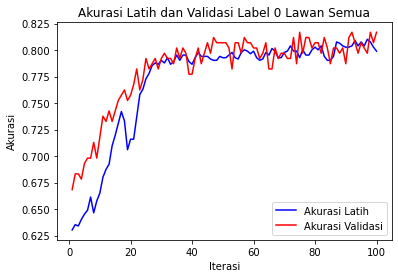

In [54]:
# plot acc train, acc val

plt.plot(iter_history, train_history, color='blue', label='Akurasi Latih')
plt.plot(iter_history, val_history, color='red', label='Akurasi Validasi')

plt.ylabel('Akurasi')
plt.xlabel('Iterasi')
plt.title("Akurasi Latih dan Validasi Label " + str(label) + " Lawan Semua")

plt.legend()
plt.show()

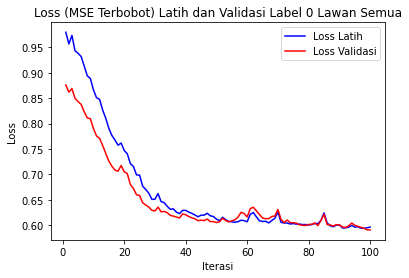

In [55]:
# plot loss train, loss val

plt.plot(iter_history, train_loss_history, color='blue', label='Loss Latih')
plt.plot(iter_history, val_loss_history, color='red', label='Loss Validasi')

plt.ylabel('Loss')
plt.xlabel('Iterasi')
plt.title("Loss (MSE Terbobot) Latih dan Validasi Label " + str(label) + " Lawan Semua")

plt.legend()
plt.show()

In [52]:
train_val_acc_hist = np.concatenate((train_history.reshape(-1,1), val_history.reshape(-1,1)), axis=1)
train_val_loss_hist = np.concatenate((train_loss_history.reshape(-1,1), val_loss_history.reshape(-1,1)), axis=1)

In [45]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt, loadtxt

def save_to_csv(data, file_name):
    # save to csv file
    savetxt(file_name, data, delimiter=',')
    
def load_from_csv(file_name):
    # load from csv file
    return loadtxt(file_name, delimiter=',')

In [53]:
save_to_csv(train_val_acc_hist, "C:/Users/user/quantum_image_classifier/PennyLane/Model & Hasil Training/" + str(label) + "/acc_hist_4_features_6layer_1.txt")
save_to_csv(train_val_loss_hist, "C:/Users/user/quantum_image_classifier/PennyLane/Model & Hasil Training/" + str(label) + "/loss_hist_4_features_6layer_1.txt")

In [300]:
# Compute predictions on train and validation set
predictions_test = [np.sign(variational_classifier(var, angles=f)) for f in feats_test]

# Compute accuracy on train and validation set
acc_test = accuracy(Y_test, predictions_test)

test_loss = cost(var, feats_test, Y_test)

print(acc_test, test_loss)

0.91 9.259276154885391


In [305]:
def confusion_matrix(labels, predictions):
    cost_matrix=np.array([[0, 0.9], [0.1, 0]])
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    # count the TP, TN, FP, and FN
    for l, p in zip(labels, predictions):
        if l == 1:
            if p == 1:
                TP += 1
            else:
                FN += 1
        else:
            if p == 1:
                FP += 1
            else:
                TN += 1
            
    # create the confusion matrix
    CM = np.array([[TN, FN], [FP, TP]])
    
    return CM

In [306]:
confusion_matrix(Y_test, predictions_test)

tensor([[89,  8],
        [ 1,  2]], requires_grad=True)